In [1]:
import generator

import numpy as np

import matplotlib.pyplot as plt

from skopt.plots import plot_gaussian_process
from skopt import Optimizer

In [2]:
bins_file = open('../exp_data/na49/binning.bin', 'r')

In [3]:
bins = []

for num, line in enumerate(bins_file.readlines()):

    if num % 2 == 0:
        
        a = line.split('|')

        for bin in a:

            bin = bin.replace('(', '').replace(')', '').replace(' ', '')
            bins.append(list(map(float, bin.split(','))))

bins = np.array(bins)

bins_file.close()

In [4]:
import pandas as pd

ids = [211, 321, -211, -321]

refs = {}

for id in ids:
    
    refs[id] = pd.read_csv(f'../exp_data/na49/{id}.csv')

In [5]:
inst = {
    'Print:quiet': 'on',

    'Beams:frameType': '2',

    'Beams:idA': '2212',
    'Beams:idB': '2212',

    'Beams:eA': '158',
    'Beams:eB': '0',

    'SoftQCD:all': 'on',

    'Tune:pp': '1',

    'SigmaDiffractive:dampen': 'on',
    'SpaceShower:phiIntAsym': 'on',
    'SpaceShower:phiPolAsym': 'on',
    'SpaceShower:rapidityOrder': 'on',
    'SpaceShower:rapidityOrderMPI': 'on',
    'SpaceShower:samePTasMPI': 'off',
    'TimeShower:dampenBeamRecoil': 'on',
    'TimeShower:phiPolAsym': 'on',

    'MultipartonInteractions:ecmRef': '1800',
    }

In [6]:
optim_param = 'MultipartonInteractions:ecmRef'

In [7]:
def objective(x, n_events, refs, agregate=None):

    new_val = x[0]

    inst[optim_param] = f'{new_val}'

    data, sigma = generator.generate(n_events, inst, bins)
    res =  generator.get_score(data, sigma, n_events, bins, refs, agregate)

    return res

In [8]:
def plot_optimizer(res, n_iter, max_iters=5):
    if n_iter == 0:
        show_legend = True
    else:
        show_legend = False
    ax = plt.subplot(max_iters, 2, 2 * n_iter + 1)
    # Plot GP(x) + contours
    ax = plot_gaussian_process(res, ax=ax,
                               #noise_level=noise_level,
                               show_legend=show_legend, show_title=True,
                               show_next_point=False, show_acq_func=False)
    ax.set_ylabel("")
    ax.set_xlabel("")
    if n_iter < max_iters - 1:
        ax.get_xaxis().set_ticklabels([])
    # Plot EI(x)
    ax = plt.subplot(max_iters, 2, 2 * n_iter + 2)
    ax = plot_gaussian_process(res, ax=ax,
                               #noise_level=noise_level,
                               show_legend=show_legend, show_title=False,
                               show_next_point=True, show_acq_func=True,
                               show_observations=False,
                               show_mu=False)
    ax.set_ylabel("")
    ax.set_xlabel("")
    if n_iter < max_iters - 1:
        ax.get_xaxis().set_ticklabels([])

In [9]:
opt_gp = Optimizer([(1., 7000.)], base_estimator="GP", n_initial_points=1,
                acq_optimizer="sampling", random_state=42)

100%|██████████| 100000/100000 [00:14<00:00, 7068.88it/s]


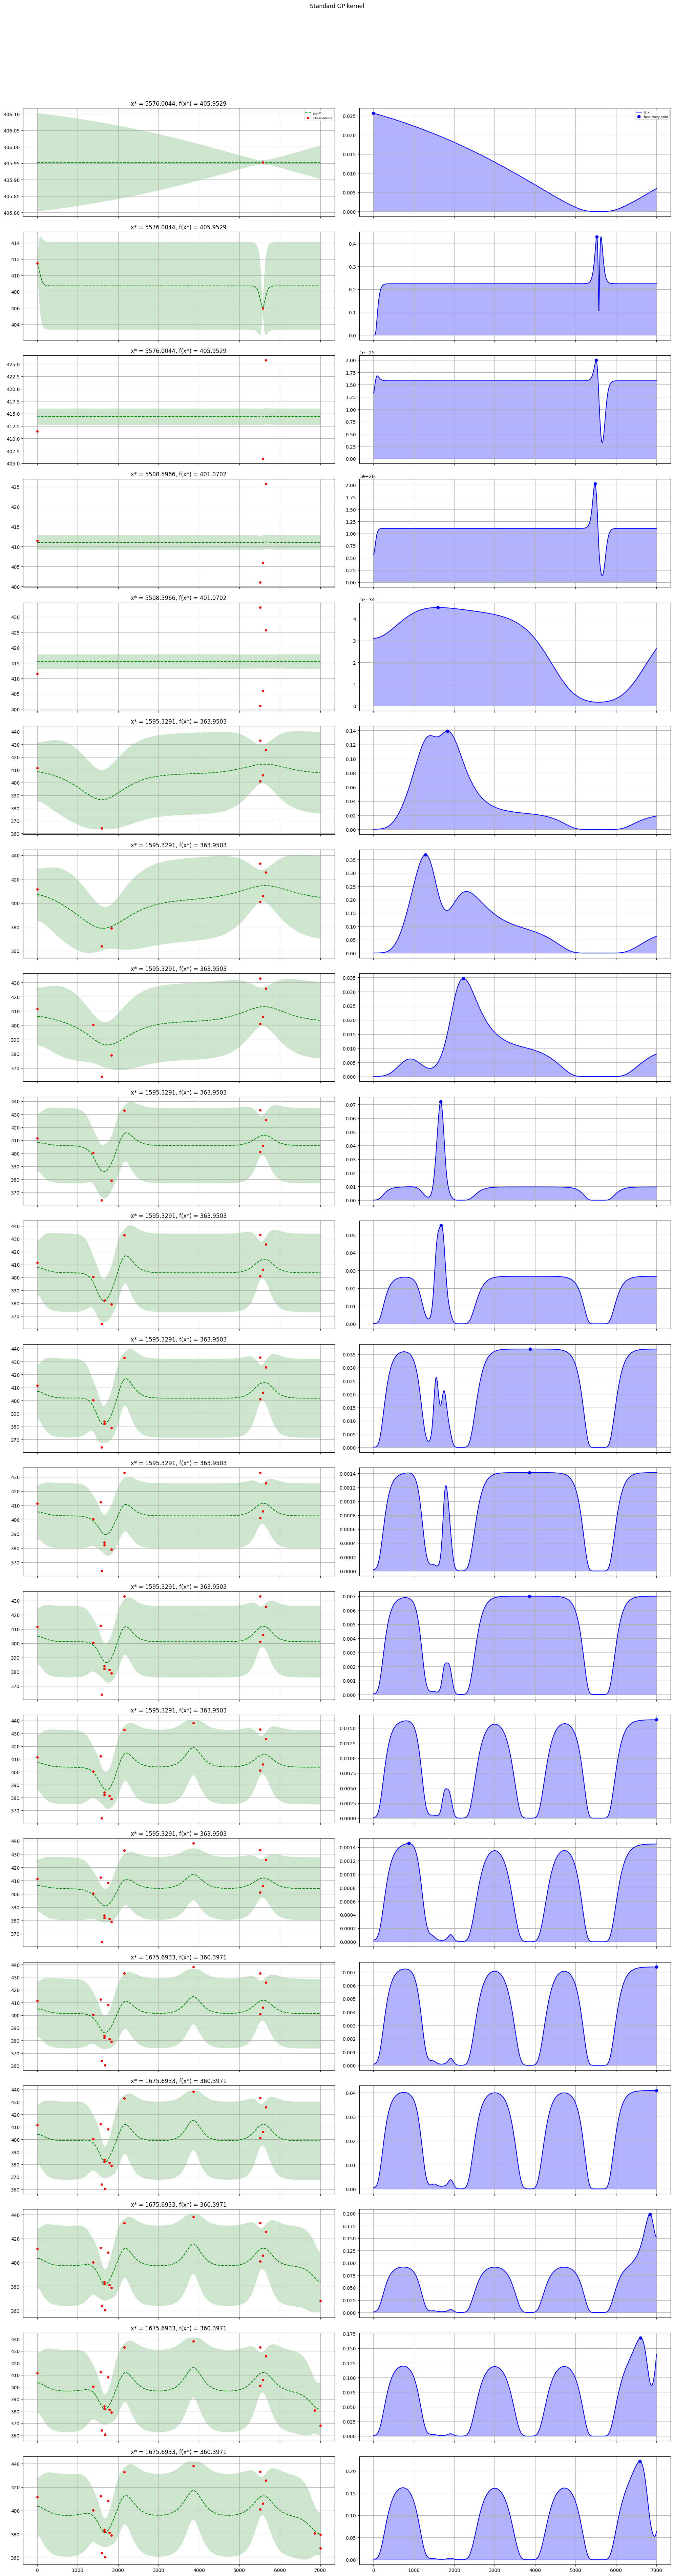

In [10]:
n_events = int(1e5)

fig = plt.figure(figsize=(20, 80))
fig.suptitle("Standard GP kernel")

itrs = 20

for i in range(itrs):
    
    next_x = opt_gp.ask()
    f_val = objective(next_x, n_events, refs, np.sum)
    res = opt_gp.tell(next_x, f_val)
    
    plot_optimizer(res, n_iter=i, max_iters=itrs)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

> ## Error evaluation

In [15]:
stat = 20
ns = [5, 6, 7]

res_pi = {}
res_k = {}

In [16]:
for n in ns:

    res_pi[n] = []
    res_k[n] = []

    print(f'Evuluate statistics for 10^{n} events:')
    
    for _ in range(stat):

        pi, k = objective([5576.0], int(10 ** n), {211: refs[211], 321: refs[321]})

        res_pi[n].append(pi)
        res_k[n].append(k)

    print('\n')

Evuluate statistics for 10^5 events:


100%|██████████| 100000/100000 [00:12<00:00, 7711.76it/s]




Evuluate statistics for 10^6 events:


100%|██████████| 1000000/1000000 [02:09<00:00, 7727.80it/s]




Evuluate statistics for 10^7 events:


100%|██████████| 10000000/10000000 [21:24<00:00, 7786.83it/s]


In [17]:
print('pi-mesons')

for n in ns:

    print(f'For 10^{n} events\n\
        Mean value: {np.mean(res_pi[n]):.5}\n\
        STD: {np.std(res_pi[n]):.5}\n')

pi-mesons
For 10^5 events
        Mean value: 137.57
        STD: 13.975

For 10^6 events
        Mean value: 118.49
        STD: 1.8588

For 10^7 events
        Mean value: 114.66
        STD: 0.55429



In [18]:
print('K-mesons')

for n in ns:

    print(f'For 10^{n} events\n\
        Mean value: {np.mean(res_pi[n]):.5}\n\
        STD: {np.std(res_pi[n]):.5}\n')

K-mesons
For 10^5 events
        Mean value: 137.57
        STD: 13.975

For 10^6 events
        Mean value: 118.49
        STD: 1.8588

For 10^7 events
        Mean value: 114.66
        STD: 0.55429

